In [64]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [65]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [66]:
f(3.0)

20.0

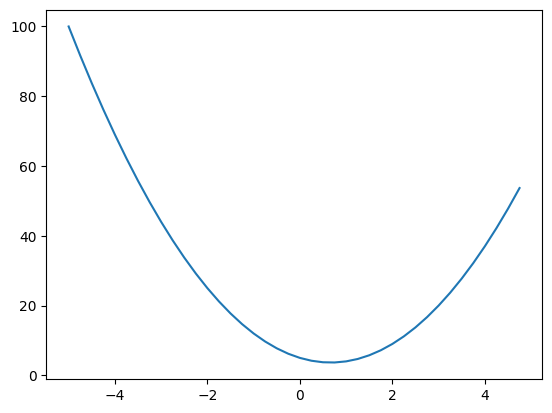

In [67]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [68]:
h = 0.000001
x = 2 / 3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [69]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [70]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [355]:
"""The main Value object in micrograd."""


class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [72]:
"""Draw the neuron network."""

from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## One neuron ↓

In [73]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"

x2w2 = x2 * w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"

o = n.tanh()
o.label = "o"

o.backward()

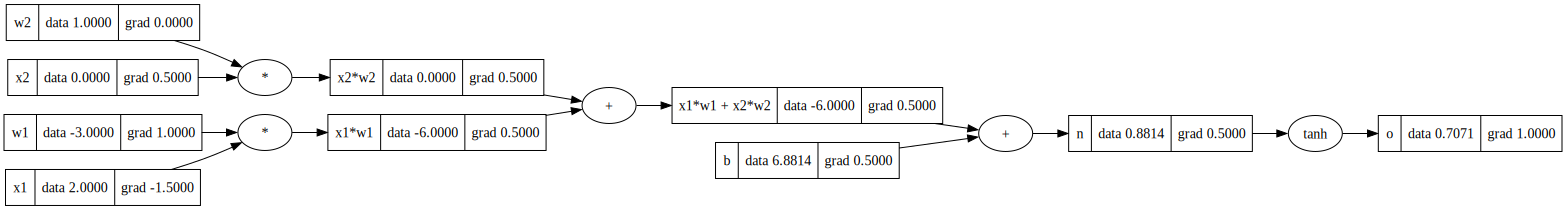

In [74]:
draw_dot(o)

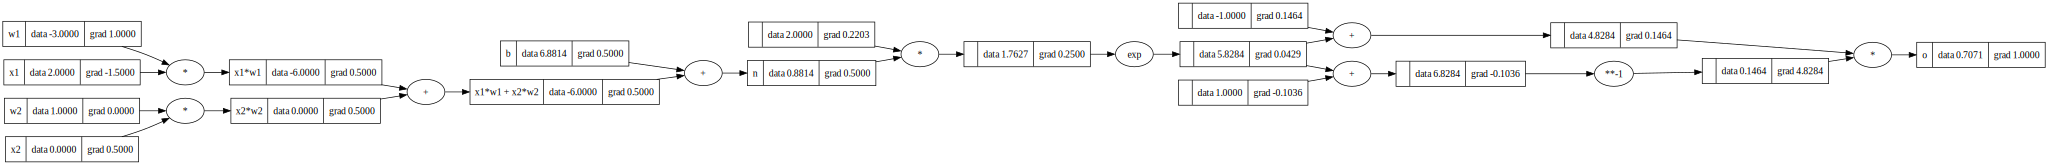

In [12]:
"""Split tanh into more atomic operation, but mathematical equivalent."""

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"

x2w2 = x2 * w2
x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b
n.label = "n"

# ----
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ----

o.label = "o"
o.backward()
draw_dot(o)

## Do the forward propagation and backpropagation in PyTorch

In [13]:
import torch

In [14]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Let's build MLP (Multiple Layer Perceptron)

In [26]:
class Neuron:
    def __init__(
        self, nin: int
    ) -> None:  # nin: The number of inputs (How many inputs come to the neuron).
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  # weight
        self.b = Value(random.uniform(-1, 1))  # bias

    def __call__(self, x: list[float]) -> Value:  # x: input
        # w * x + b: This is the transformation/operation that the neuron does to the input.
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)  # Activation
        # Before return, take the data through the non-linearity function, in this case, the
        # tanh.
        out = act.tanh()
        return out

    def parameters(self) -> list[Value]:
        return self.w + [self.b]


class Layer:
    def __init__(self, nin: int, nout: int) -> None:
        # This results in a layer of Neuron objects whose number is determined by the
        # nout parameter. Each Neuron object understands that it will receive nin inputs.
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: list[float]) -> Value | list[Value]:
        # Call each neuron n in the layer with the input x. Every neuron performs its
        # operation on the input x, and the output of each neuron is collected in the
        # list outs.
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self) -> list[Value]:
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: list[int]) -> None:
        # size = The number of inputs (nin) + the number of neurons in each layer
        sz = [nin] + nouts
        # For each layer i, we pass sz[i] and sz[i + 1] as nin and nout to create the
        # layer, so essentially sz[i] gives us the number of neurons in the previous
        # layer (which will be used as inputs to the current layer) and sz[i + 1]
        # gives us the number of neurons in the current layer.
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x: list[float]) -> Value | list[Value]:
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self) -> list[Value]:
        return [p for layer in self.layers for p in layer.parameters()]

### 3 inputs, 2 layers, 4 neurons, 1 output MLP

In [364]:
"""
Initialize our two layers MLP (each layer consists of 4 neurons). Feed some data
to it.
"""
x = [2.0, 3.0, -1.0]
# Initialize MLP with two layers (Each layer has four neurons), one output. As of
# this point, no computation has occurred yet, because we haven't fed data into.
n = MLP(3, [4, 4, 1])
# This call ↓ calls the `__call__` method of the initialized MLP instance, which
# successively calls the `__call__` method of each Layer object and subsequently
# each Neuron object. The computation (w * x + b) is performed.
n(x)

Value(data=0.6925839523802495)

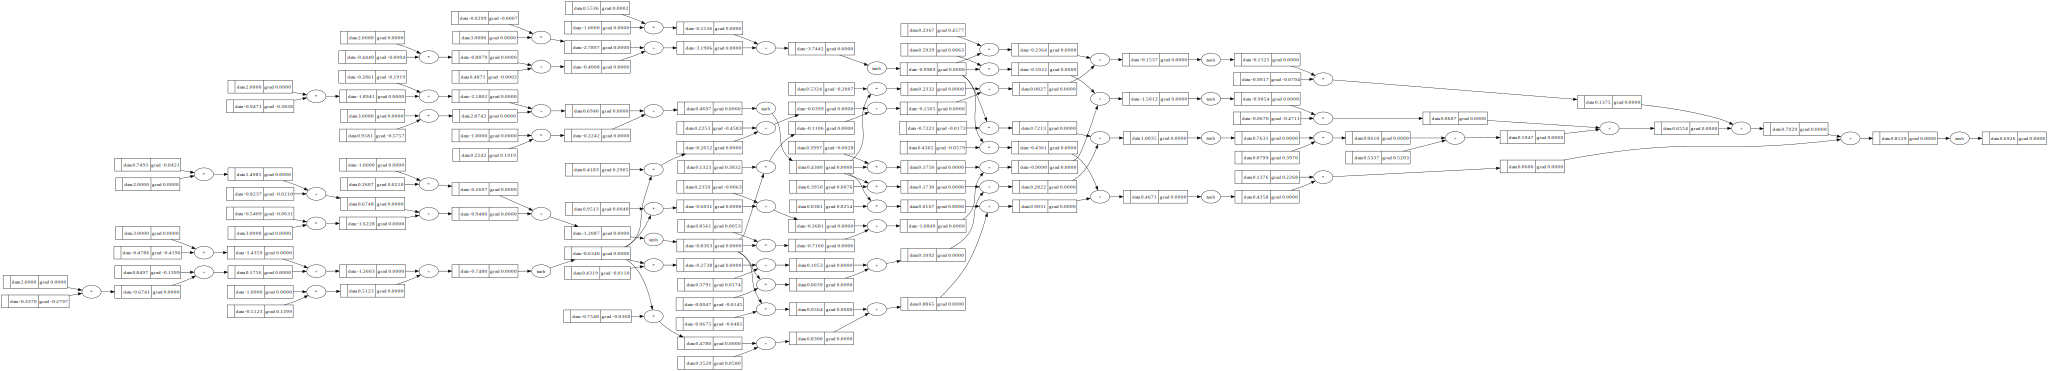

In [365]:
"""
3 inputs to the two layers MLP, produce an output n. Let's see how it goes in the 
graph.
"""
n(x).backward()
# Now we can graph the network. In this stage, no gradient is computed.
draw_dot(n(x))

In [371]:
"""It has 41 parameters (weight + bias) that we can control."""

n.parameters()

[Value(data=-0.3370324757053651),
 Value(data=-0.4786475254790614),
 Value(data=-0.5122674900379827),
 Value(data=0.8497065440076308),
 Value(data=0.7492540313600191),
 Value(data=-0.5409192564614445),
 Value(data=0.2607499126549164),
 Value(data=-0.823713266647004),
 Value(data=-0.9470624182295619),
 Value(data=0.9580674057346594),
 Value(data=0.2242461646126197),
 Value(data=-0.28608943240100726),
 Value(data=-0.443963117846526),
 Value(data=-0.9299124650831985),
 Value(data=0.5536163423545131),
 Value(data=0.4870896334860997),
 Value(data=0.43190334998299074),
 Value(data=-0.004680606746196414),
 Value(data=0.394975759626663),
 Value(data=-0.7221321514707844),
 Value(data=0.379117927817179),
 Value(data=0.9512706183178257),
 Value(data=0.8561234036532976),
 Value(data=0.3996545051103826),
 Value(data=0.5928515757728274),
 Value(data=0.2350018303198098),
 Value(data=0.4182525810762483),
 Value(data=0.1322834430618538),
 Value(data=0.5324196796897802),
 Value(data=0.23668283328367545)

### Starting predict

In [372]:
"""Feed a decent dataset to our very simple MLP."""

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 0.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6925839523802495),
 Value(data=0.5198243059924658),
 Value(data=0.45573778867266496),
 Value(data=0.5965047457815713)]

In [373]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))  # Mean Square Error
loss

Value(data=4.879360968529147)

In [374]:
loss.backward()

In [375]:
n.layers[0].neurons[0].w[0].grad

-3.953518403961575

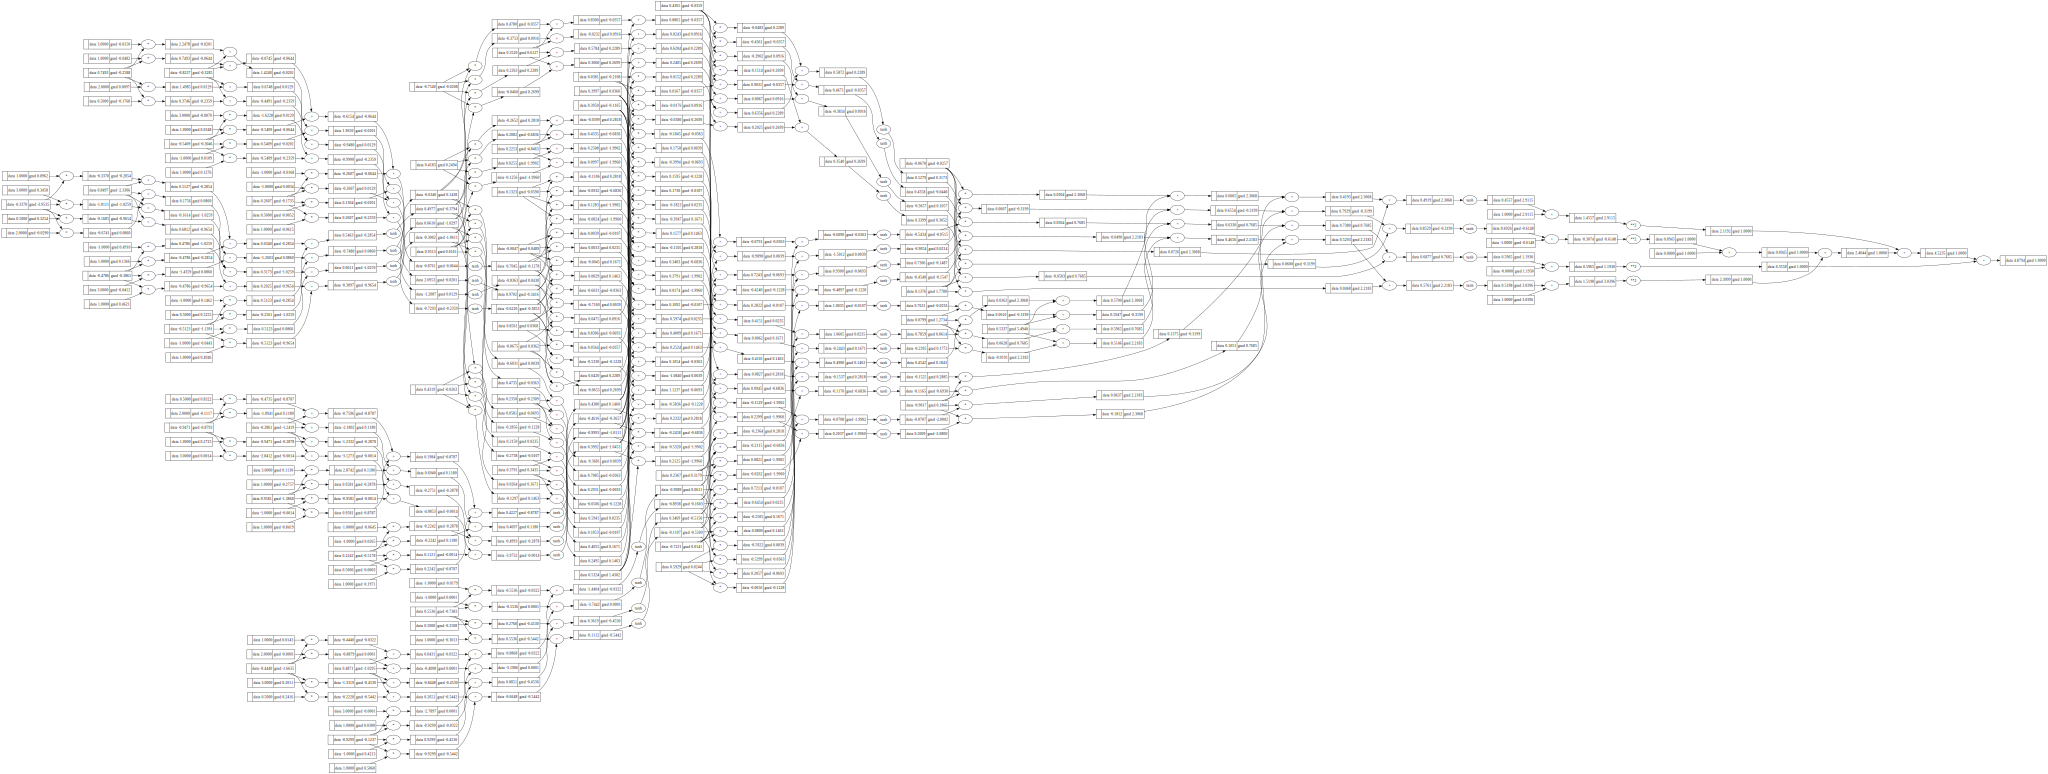

In [376]:
"""
Dataset is processed by our MLP, then measured by loss function in the end. Our 
goal is to minimize the loss function.
"""
draw_dot(loss)

In [406]:
"""
Training process. Nudge the parameters (weight and bias) in the direction that minimize
loss function. 
"""

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.0035615817823186143
1 0.0036021077218801843
2 0.0035280572813364136
3 0.0035675495790030735
4 0.0034944244424991115
5 0.003532973637327993
6 0.0034608668871488994
7 0.0034985695125674785
8 0.003427563753752214
9 0.0034645196210428427
10 0.003394685311071586
11 0.0034309949906681063
12 0.003362389292133782
13 0.003398151845848531
14 0.003330817968447631
15 0.0033661289646210197
16 0.0033000959472524218
17 0.0033350457723744682
18 0.0032703286465624623
19 0.00330500111196521


In [407]:
ypred

[Value(data=0.9719779111551797),
 Value(data=-0.990383192791454),
 Value(data=-0.9772203280943458),
 Value(data=-0.04368486254668332)]